In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [158]:
#visualization functions

%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 6]

def set_grid_and_ticks(ax):
    perc_ticks = np.arange(0, 1, 0.05)
    days_ticks = np.arange(0, 21, 1)
    a = ax.set_xticks(days_ticks)
    a = ax.set_yticks(perc_ticks)
    ax.grid(alpha=0.5)

In [163]:
df = pd.read_csv('/users/alonag/LT_surv.csv')

In [164]:
df.columns = ['ID','req_day','bad_req_day',
              'bad_req_rate','user_life','days_with_bad_req',
              'active_days','non_active_days']

df.iloc[:,1:].tail(5)

,req_day,bad_req_day,bad_req_rate,user_life,days_with_bad_req,active_days,non_active_days
59724,1.0,1.0,1.0,7,2,2,5
59725,1.0,1.0,1.0,1,1,1,0
59726,1.0,1.0,1.0,1,1,1,0
59727,1.0,1.0,1.0,12,1,1,10
59728,1.0,1.0,1.0,2,1,1,0


In [165]:
# add event col
df['event'] = [1 if num < 21 else 0 for num in df['user_life']]
# add another ratio
df['non_active_days_rate'] = df['non_active_days'] / df['active_days']  


In [166]:
df.iloc[:,1:].describe()

,req_day,bad_req_day,bad_req_rate,user_life,days_with_bad_req,active_days,non_active_days,event,non_active_days_rate
count,59729.000000,59729.000000,59729.000000,59729.000000,59729.000000,59729.000000,59729.000000,59729.000000,59729.000000
mean,1.615442,1.564757,0.988017,3.944349,2.030588,2.137722,2.674312,0.990105,0.787557
std,1.950017,1.829507,0.077426,4.341374,1.659509,2.038321,4.252198,0.098980,1.230605
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,1.571429,1.500000,1.000000,5.000000,2.000000,2.000000,4.000000,1.000000,1.222222
max,57.227273,43.500000,1.000000,22.000000,14.000000,22.000000,21.000000,1.000000,12.000000


In [167]:
df['event'].value_counts()

1    59138
0      591
Name: event, dtype: int64

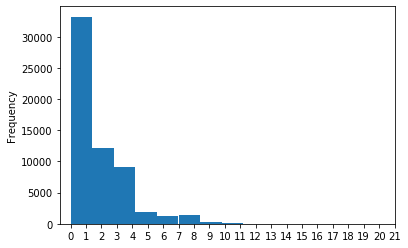

In [184]:
#days in which the user created bad requests

plt.rcParams['figure.figsize'] = [6, 4]

x = df['days_with_bad_req'].plot.hist().set_xticks(np.arange(0,22,1))

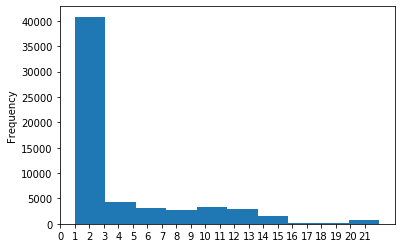

In [180]:
#days in which the user made ANY requests

x = df['user_life'].plot.hist().set_xticks(np.arange(0,22,1)) 

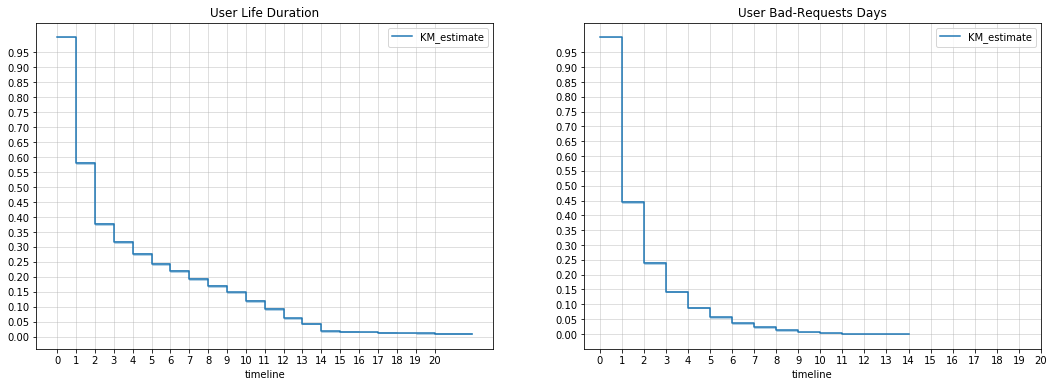

In [189]:
from lifelines import KaplanMeierFitter
kmf_life = KaplanMeierFitter()
kmf_breq = KaplanMeierFitter()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

kmf_life.fit(df['user_life'], event_observed=df['event'])
x = kmf_life.plot(ax=ax[0])
set_grid_and_ticks(x)
x = ax[0].set_title("User Life Duration")

kmf_breq.fit(df['days_with_bad_req'], event_observed=df['event'])
x = kmf_breq.plot(ax=ax[1])
set_grid_and_ticks(x)
x = ax[1].set_title("User Bad-Requests Days")

In [199]:
print(f'5% of the population will make bad requests after {kmf_breq.percentile(0.05)} days')
print(f'75% of the population will make bad requests after {kmf_breq.percentile(0.75)} days')
print(f'50% of the population (median) will make bad requests after {kmf_breq.percentile(0.50)} days')
print('-----------------')
print(f'No one will make bad requests after: {kmf_breq.percentile(0)} days')

5% of the population will make bad requests after 6.0 days
75% of the population will make bad requests after 1.0 days
50% of the population (median) will make bad requests after 1.0 days
-----------------
No one will make bad requests after: 14.0 days


In [213]:
print(f'Probability that user will made BAD requests after 3 days is: {kmf_breq.predict(14)}')
print(f'Probability that user will made ANY requests after 3 days is: {kmf_life.predict(14)}')

Probability that user will made BAD requests after 3 days is: 0.0
Probability that user will made ANY requests after 3 days is: 0.017612884863299254


In [214]:
from lifelines import CoxPHFitter

df_reg = df.loc[:,['event','req_day','bad_req_rate','non_active_days_rate', 'days_with_bad_req']]
cp = CoxPHFitter()
cp.fit(df_reg, duration_col='days_with_bad_req', event_col='event')
cp.print_summary()

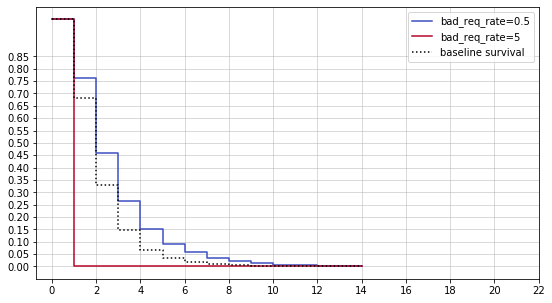

In [228]:
ax = cp.plot_covariate_groups('bad_req_rate', [0.5, 5], cmap='coolwarm')
plt.rcParams['figure.figsize'] = [9, 5]
perc_ticks = np.arange(0, 0.9, 0.05)
days_ticks = np.arange(0, 24, 2)

a = ax.set_xticks(days_ticks)
ax.set_xticks(days_ticks, minor=True)
a = ax.set_yticks(perc_ticks)
ax.set_yticks(perc_ticks, minor=True)
ax.grid(alpha=0.6)


In [271]:
plt.rcParams['figure.figsize'] = [4, 3]

def get_sample_user(event, req_day, bad_req_rate, non_active_days_rate, days_with_bad_req):
    user = np.array([
        event,
        req_day,
        bad_req_rate,
        non_active_days_rate,
        days_with_bad_req])

In [272]:
plt.rcParams['figure.figsize'] = [4, 3]

def get_sample_user(event, req_day, bad_req_rate, non_active_days_rate, days_with_bad_req):
    user = np.array([
        event,
        req_day,
        bad_req_rate,
        non_active_days_rate,
        days_with_bad_req])
    
    return pd.DataFrame(user.reshape(1,-1),columns=df_reg.columns)

In [273]:
user_a_df = get_sample_user(0,10,2,0.3,4)

print(user_a_df)

   event  req_day  bad_req_rate  non_active_days_rate  days_with_bad_req
0    0.0     10.0           2.0                   0.3                4.0


expected # of days with bad requests: 2.1991465130749517 days


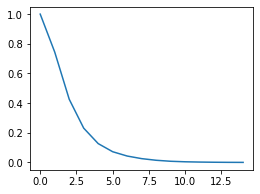

In [278]:
surv = cp.predict_survival_function(user_a_df)
plt.plot(surv)

print(f'expected # of days with bad requests: {cp.predict_expectation(user_a_df)[0]} days')

In [279]:
user_b_df = get_sample_user(0,10,4,0.3,4)
print(user_b_df)

   event  req_day  bad_req_rate  non_active_days_rate  days_with_bad_req
0    0.0     10.0           4.0                   0.3                4.0


expected # of days with bad requests: 0.7955273872143215 days


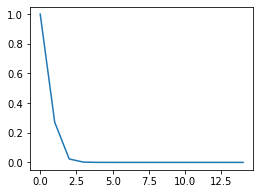

In [280]:
surv = cp.predict_survival_function(user_b_df)
plt.plot(surv)

print(f'expected # of days with bad requests: {cp.predict_expectation(user_b_df)[0]} days')